In [1]:
import h5py, sys, os
import numpy as np
from scipy.special import j1
from scipy.signal import hilbert2
from scipy import ndimage
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyhank import HankelTransform
from matplotlib import colors
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir = '/store/ATMOS/cwp29/data/waves/wide/'
simulations = ['hres/N_1/', 'N_1', 'N_2', '../testing/N_10']
zplots = [0.45, 0.45, 0.35, 0.25]

version = "3.12"

wave_freqs = []
plume_freqs = []

for d in range(len(simulations)):
    print(simulations[d])
    save_dir = join(base_dir, simulations[d])
    
    # Load simulation metadata
    md = get_metadata(run_dir=save_dir, version="3.12")
    
    # Load grids
    _, _, gzf, _ = get_grid(md, save_dir=save_dir)

    #Load simulation data
    var1, phi, times = load_data('w_xz', 'th2_xz', save_dir=save_dir)
    NSAMP = len(times)

    times, t0_idx = calibrate_time(save_dir, times)

    buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
    md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
    md['SAVE_STATS_DT'] *= buoy_per
    md['SAVE_STATS_DT_FINE'] *= buoy_per
    tend_idx = len(times)-1
    tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
    print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
    print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
    print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))

    zmin = 0.3
    zmax = 0.5
    zmin_idx = get_index(zmin, gzf)
    zmax_idx = get_index(zmax, gzf)

    var1_filtered = np.zeros_like(var1)

    for i in range(NSAMP):
        var1_filtered[i] = ndimage.gaussian_filter(var1[i], 1)

    waves = var1_filtered[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, :]

    N = np.sqrt(md['N2'])

    waves_t = np.fft.fft(waves, axis=0) # time FFT
    freq_m = np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']
    waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
    waves_t *= 2 # preserve energy
    wavesHT = np.fft.ifft(waves_t, axis=0)
    waves_txz = np.fft.fft2(wavesHT) # spatial FFT
    
    wavenumber_z = np.fft.fftfreq(waves.shape[1])*2*np.pi*md['Nz']/md['LZ']
    wavenumber_x = np.fft.fftfreq(waves.shape[2])*2*np.pi*md['Nx']/md['LX']

    waves_right = np.copy(waves_txz)
    waves_left = np.copy(waves_txz)

    waves_right[:, :, wavenumber_x >= 0] = 0 # isolate rightward moving waves
    waves_left[:, :, wavenumber_x <= 0] = 0 # isolate leftward moving waves

    waves_right = np.fft.ifft2(waves_right)
    waves_left = np.fft.ifft2(waves_left)

    # Plot frequency and wavenumber spectra
    zplot = zplots[d]
    gzf_trunc = gzf[zmin_idx:zmax_idx+1]
    times_trunc = np.concatenate(([times[tstart_idx]-md['SAVE_STATS_DT_FINE']], times[tstart_idx:tend_idx+1]))

    stacked_right = np.real(waves_right[:, get_index(zplot, gzf_trunc), :])
    stacked_right = np.flip(stacked_right, axis=0) # flip data
    right_ft = np.fft.fft2(stacked_right)
    right_ft = np.fft.fftshift(right_ft)

    stacked_left = np.real(waves_left[:, get_index(zplot, gzf_trunc), :])
    left_ft = np.fft.fft2(stacked_left)
    left_ft = np.fft.fftshift(left_ft)
    
    freq = -np.fft.fftfreq(stacked_right.shape[0])*2*np.pi/md['SAVE_STATS_DT_FINE']
    freq = np.fft.fftshift(freq)
    wavenumber = np.fft.fftfreq(stacked_right.shape[1])*2*np.pi*md['Nx']/md['LX']
    wavenumber = np.fft.fftshift(wavenumber)
    
    power_r = np.power(np.abs(right_ft), 2)
    power_l = np.power(np.abs(left_ft), 2)

    ##### Calculate characteristic frequency #####
    omega_c_l = 0
    norm_l = 0
    omega_c_r = 0
    norm_r = 0
    
    N = np.sqrt(md['N2'])
    
    amp2_l = np.mean(power_l, axis=1)
    amp2_r = np.mean(power_r, axis=1)
    
    for i in range(len(freq)):
        if N >= freq[i] >= 0:
            norm_l += amp2_l[i]
            omega_c_l += freq[i]*amp2_l[i]
            norm_r += amp2_r[i]
            omega_c_r += freq[i]*amp2_r[i]
    
    omega_c_l /= norm_l
    omega_c_r /= norm_r
    
    omega_c = 0.5*(omega_c_l/N+omega_c_r/N)
    
    # Calculate plume frequency
    
    tracer_thresh = 1e-3
    
    tracer_data_full = np.where(phi >= tracer_thresh, phi, 0)
    plume_full = np.where(tracer_data_full >= tracer_thresh, 1, 0)
    
    heights = []
    for i in range(len(plume_full)):
        stuff = np.where(plume_full[i] == 1)[0]
        if len(stuff) == 0:
            heights.append(0)
        else:
            heights.append(gzf[np.max(stuff)+1])
    
    times = times[tstart_idx:]
    heights = heights[tstart_idx:]
    heights -= np.mean(heights)
    
    freq_spectrum = np.fft.rfft(heights)
    freq = np.fft.rfftfreq(len(heights)) * 2*np.pi/md['SAVE_STATS_DT_FINE']
    
    plume_spectrum = np.power(np.abs(freq_spectrum),2)
    
    omega_plume = 0
    norm = 0
    
    for i in range(np.where(freq <= 5)[0][-1]):
        norm += plume_spectrum[i]
        omega_plume += freq[i]*plume_spectrum[i]
    
    omega_plume /= norm
    omega_plume /= N

    wave_freqs.append(omega_c)
    plume_freqs.append(omega_plume)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
hres/N_1/
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Plume penetration occured at t=2.3545
25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods
N_1
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz'

[1.1955791954974002, 1.5310837243095599, 1.1056894211654715, 0.17111071097983624]
[0.8034960444834215, 0.7645740804334517, 0.5862130034431312, 0.7094354547945336]


(0.0, 2.0)

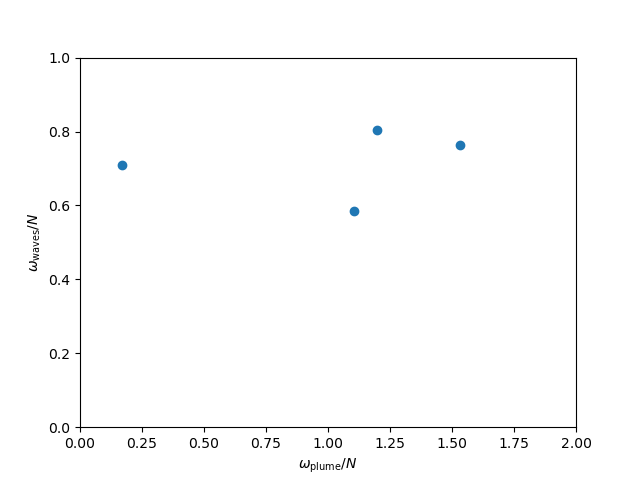

In [2]:
print(plume_freqs)
print(wave_freqs)

fig = plt.figure()

plt.plot(plume_freqs, wave_freqs, "o")

plt.xlabel(r"$\omega_{\mathrm{plume}}/N$")
plt.ylabel(r"$\omega_{\mathrm{waves}}/N$")

plt.ylim(0, 1)
plt.xlim(0, 2)